In [133]:
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [135]:
from sklearn.datasets import fetch_openml

In [137]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [138]:
X,y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [139]:
y = y.astype(np.uint8)

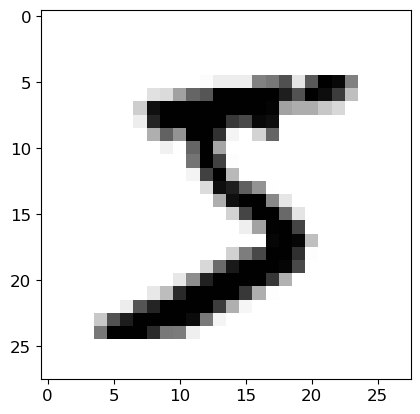

label 5


In [140]:
some_ditgit = X[0]
plt.imshow(some_ditgit.reshape(28,28), cmap="binary")
plt.show()
print("label",y[0])

# Chuẩn bị dữ liệu

In [142]:
X_train, y_train, X_test, y_test = X[:60000],y[:60000], X[60000:], y[60000:]

# Phân loại nhị phân (Binary Classification)

In [144]:
#5 và không phải 5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

#### Huấn luyện và đánh giá mô hình cho bài toán phân loại nhị phân

#### Accuracy

In [147]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [148]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [149]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
def cross_val_accuracy_with_stratifiedkfold(model, skfolds, X_train, y_train):
    score = []
    for train_index, test_index in skfolds.split(X_train, y_train):
        clone_clf = clone(model)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        accuracy = (n_correct / len(y_pred))
        score.append(accuracy)
    return score

scores = cross_val_accuracy_with_stratifiedkfold(sgd_clf, skfolds, X_train, y_train_5)

In [150]:
print("Độ chính xác cross-validation phân tầng:", scores)
print("Độ chính xác trung bình:", np.mean(scores))
print("Độ lệch chuẩn:", np.std(scores))

Độ chính xác cross-validation phân tầng: [0.9669, 0.91625, 0.96785]
Độ chính xác trung bình: 0.9503333333333334
Độ lệch chuẩn: 0.024103676529156744


In [151]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [158]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train_5, y_train_pred)

0.9570333333333333

#### Confusion matrix

In [160]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### Precision 

In [162]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

#### Recall

In [164]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

#### F1-score

In [166]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

#### Precision, recall for each threshold 

In [168]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [169]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

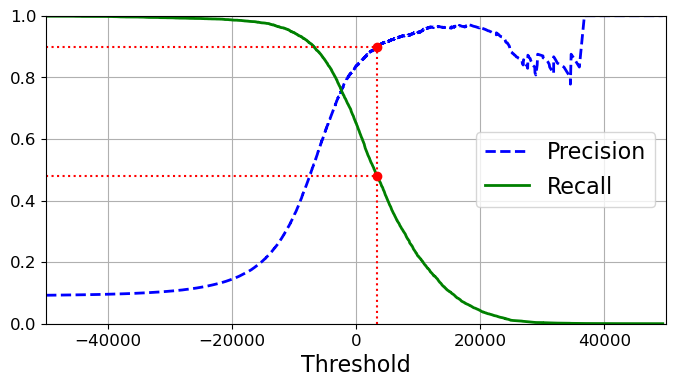

In [170]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                            
plt.show()

#### Precision, recall trade off

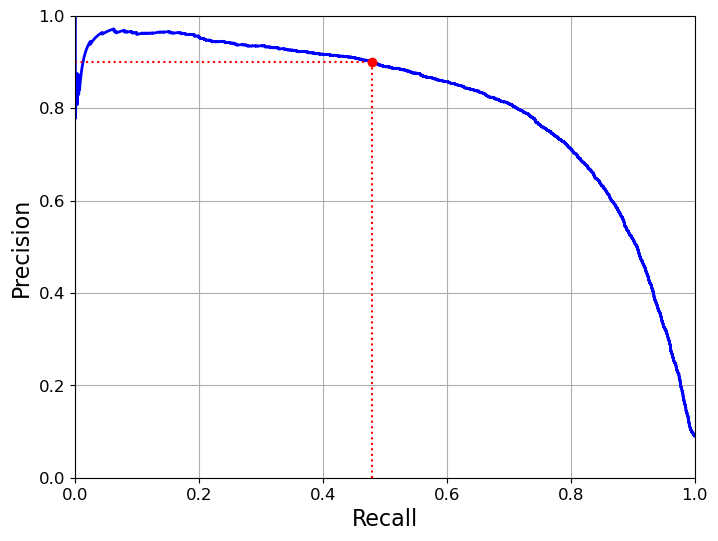

In [172]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [173]:
#chọn ngưỡng sao cho precision = 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [174]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


#### Roc curve

In [176]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

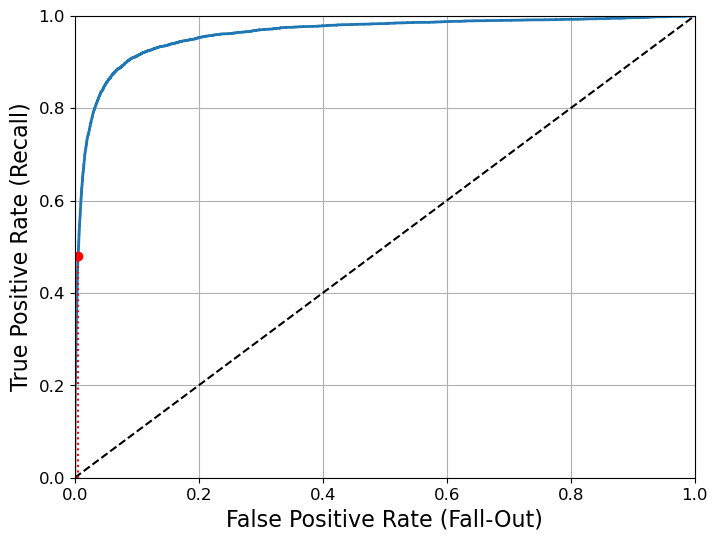

In [177]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")  
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

In [178]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [179]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [180]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [181]:
y_scores_forest = y_probas_forest[:, 1] #xac suat cua lop 5 (positive class)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

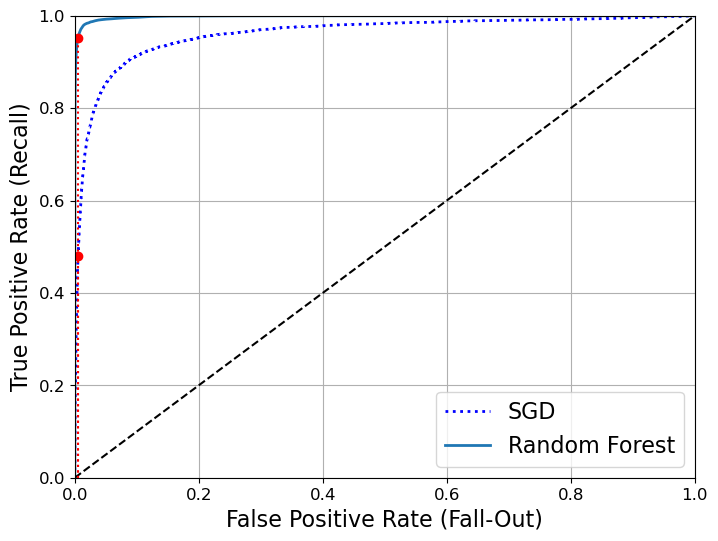

In [182]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [183]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [184]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [185]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


# Phân loại đa lớp (multi-class classification)

In [187]:
X_train, y_train, X_test, y_test = X[:60000],y[:60000], X[60000:], y[60000:]

#### Huấn luyện và đánh giá mô hình cho bài toán phân loại đa lớp

In [189]:
#SVM
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train, y_train) 

SVC(gamma='auto', random_state=42)

In [ ]:
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
#Sử dụng OvR for SVM
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train, y_train)

In [ ]:
cross_val_score(ovr_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=3)
knn_clf.fit(X_train, y_train)

In [ ]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

#### Phân tích lỗi

In [110]:
y_train_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5823,    4,   17,    7,    0,   19,   41,    4,    5,    3],
       [   2, 6664,   19,   12,    7,    3,   14,   11,    6,    4],
       [  65,   51, 5543,   89,   30,    9,   49,   52,   43,   27],
       [  13,   20,   54, 5768,    5,   96,    7,   69,   69,   30],
       [   4,   62,   46,    7, 5432,   16,   25,   37,   14,  199],
       [  23,   11,   11,  149,   10, 5011,   94,   14,   48,   50],
       [  57,   13,   15,    5,   11,   51, 5759,    1,    6,    0],
       [  10,   51,   27,   15,   61,    2,    0, 5871,    4,  224],
       [  47,   75,   37,  105,   37,  179,   37,   20, 5240,   74],
       [  18,    8,   19,   46,  111,   12,    1,  204,   15, 5515]],
      dtype=int64)

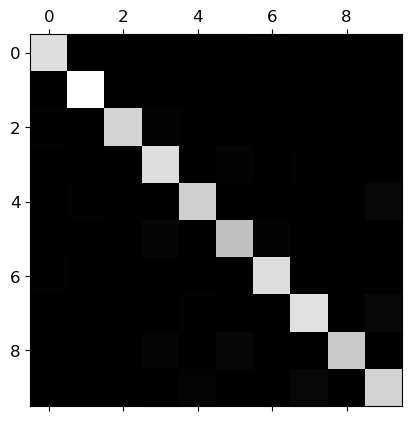

In [111]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [112]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

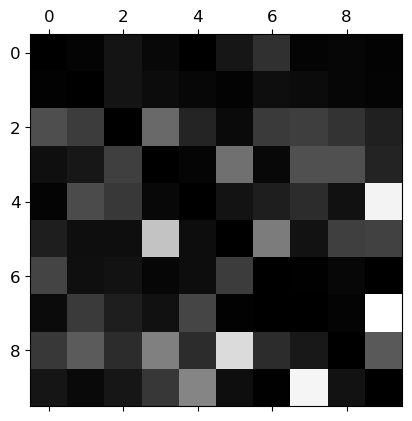

In [113]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

#### Tinh chỉnh

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, scoring="accuracy")
grid_search.fit(X_train, y_train)

In [ ]:
print("Bộ siêu tham số tốt nhất:", grid_search.best_params_)
print("Độ chính xác tốt nhất trên tập huấn luyện (cross-validation):", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nĐộ chính xác trên tập kiểm tra:", test_accuracy)

#### Data argumentation

In [121]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

C:\Users\HO KHOI\AppData\Local\Temp\ipykernel_11872\2707933203.py:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


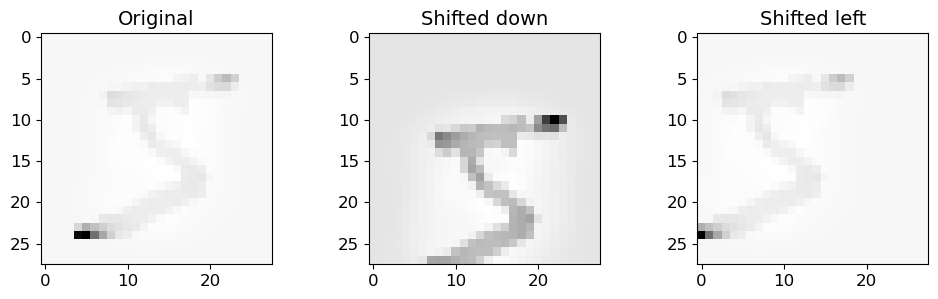

In [123]:
image = X_train[0]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)

plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [124]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [126]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

MemoryError: Unable to allocate 1.75 GiB for an array with shape (300000, 784) and data type float64

In [130]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [131]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

MemoryError: Unable to allocate 1023. MiB for an array with shape (447, 300000) and data type float64

-> Data argumentation giúp tăng độ chính xác lên 0.5%

# Phân lớp đa nhãn Multi-label classification

#### Huấn luyện và đánh giá mô hình cho bài toán phân loại đa nhãn

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

# Phân loại đa đầu ra (Multioutput classification)

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
plt.imshow(X_train_mod[0].reshape(28,28), cmap = mpl.cm.binary)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plt.imshow(clean_digit.reshape(28,28),cmap=mpl.cm.binary)